# Convolutional Neural Network (Predicting Vegetables)
### Kaung Myat San (P2408655)
### DAAA/FT/2B/22
### Date: 6.5.2025
---

## Background Research & Data Analysis
---

### Dataset Overview

* **Image Size**: 224 × 224 pixels (3 color channels)
* **Number of Classes**: **13**, but grouped into **11**
* **Classes**:

  * Bean
  * Bitter Gourd
  * **Bottle Gourd and Cucumber** *(grouped)*
  * Brinjal *(Eggplant)*
  * **Broccoli and Cauliflower** *(grouped)*
  * Cabbage
  * Capsicum *(Bell Pepper)*
  * **Carrot and Radish** *(grouped)*
  * Potato
  * Pumpkin
  * Tomato

> **Note**: Some vegetables are grouped due to their **visual similarity**, especially when images are **grayscale**.

---

### Irregularities

#### Test Folder

* **Pumpkin** and **Tomato** folders seem to contain images of **each other's vegetables**.

#### Train Folder

* **Bean** folder:

  * Files from `0001.jpg` to `0020.jpg`, `0033.jpg`, `0049.jpg` to `0050.jpg` appear to be **carrots**, not beans.


###  Tasks to Complete

1. **Correct Dataset Irregularities**

   * Identify and move misclassified images to their correct folders.

2. **Standardize Folder Names Across All Splits**

   * Ensure consistent naming for all class folders in the `train`, `test`, and `validation` directories.
   
---


## Setup
---


### Importing Modules

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

#### Configuring GPU

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [25]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Augmentation
---

In [26]:
# Function to load images from a folder
# and preprocess them for the model

def load_images_from_folder(root_dir, subfolders, target_size):
    # Known issues
    mislabel_test = {'Pumpkin (purportedly)': 'Tomato', 'Tomato (ostensibly)': 'Pumpkin', 'Capsicum (apparently)': 'Capsicum'}
    mislabel_train = {
        'Cucumber and Bottle_Gourd': 'Bottle_Gourd and Cucumber',
        'Cauliflower and Broccoli': 'Broccoli and Cauliflower',
        'Radish and Carrot': 'Carrot and Radish',
        'Bean': [1, 2, 3, 4, 17, 18, 19, 20, 33, 49, 50] # 0001.jpg to 0020.jpg, 0033.jpg, 0049.jpg, 0050.jpg are carrots
    }

    mislabel_validation = {
        'Cauliflower with Broccoli': 'Broccoli and Cauliflower',
        'Cucumber with Bottle_Gourd': 'Bottle_Gourd and Cucumber',
        'Radish with Carrot': 'Carrot and Radish'
    }
    # Data storage
    data = []

    def correct_label(path, fname, folder):
        folder_name = os.path.basename(os.path.dirname(path))

        # Test mislabels
        if folder == 'test' and folder_name in mislabel_test:
            return mislabel_test[folder_name]

        # Train mislabels
        if folder == 'train' and folder_name in mislabel_train and folder_name != 'Bean':
            return mislabel_train[folder_name]

        # Validation mislabels (except Bean)
        if folder == 'validation' and folder_name in mislabel_validation:
            return mislabel_validation[folder_name]

        # Train/Validation Bean-specific logic (check filename index)
        if folder =="train" and folder_name == 'Bean':
            match = re.match(r'(\d+)', fname)
            if match:
                idx = int(match.group(1))
                if idx in mislabel_validation.get('Bean', []) or idx in mislabel_train.get('Bean', []):
                    return 'Carrot and Radish'

        # Default
        return folder_name

    # Traverse the dataset
    for split in subfolders:
        split_path = os.path.join(root_dir, split)

        for class_folder in os.listdir(split_path):
            class_path = os.path.join(split_path, class_folder)
            if not os.path.isdir(class_path): # continue if not a directory
                continue
            for fname in tqdm(os.listdir(class_path), desc=f"Processing {split}/{class_folder}"):
                img_path = os.path.join(class_path, fname)
                try:
                    # Load in grayscale and resize
                    img = load_img(img_path, color_mode='grayscale', target_size=target_size)
                    img_array = img_to_array(img)  # shape: (101, 101, 1)
                    img_array = img_array / 255.0  # normalize to 0–1
                    img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 101, 101, 1)

                    label = correct_label(img_path, fname, split)
                    data.append({'image': img_array, 'label': label, 'split': split})
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    # Convert to DataFrame
    dataset = pd.DataFrame(data)
    label_dummies = pd.get_dummies(dataset['label'], prefix='label')

    # Join with original dataframe and drop the original 'label' column
    dataset = pd.concat([dataset.drop('label', axis=1), label_dummies], axis=1)
    dataset.rename(columns=lambda col: col.replace('label_', '') if col.startswith('label_') else col, inplace=True)
    return dataset

In [27]:
# Define root and subfolders
root_dir = 'Dataset_A'
subfolders = ['train', 'test', 'validation']
target_size = (101, 101)

# Load images
dataset101 = load_images_from_folder(root_dir, subfolders, target_size)

target_size = (23, 23) 
# Load images
dataset23 = load_images_from_folder(root_dir, subfolders, target_size)

Processing validation/Tomato: 100%|██████████| 200/200 [00:00<00:00, 1879.50it/s]


In [28]:
dataset101.head()

,image,split,Bean,Bitter_Gourd,Bottle_Gourd and Cucumber,Brinjal,Broccoli and Cauliflower,Cabbage,Capsicum,Carrot and Radish,Potato,Pumpkin,Tomato
0,"[[[[0.23921569], [0.20392157], [0.25490198], [...",train,False,False,False,False,False,False,False,True,False,False,False
1,"[[[[0.7372549], [0.7372549], [0.7372549], [0.7...",train,False,False,False,False,False,False,False,True,False,False,False
2,"[[[[0.42745098], [0.42352942], [0.4117647], [0...",train,False,False,False,False,False,False,False,True,False,False,False
3,"[[[[0.22352941], [0.20784314], [0.18431373], [...",train,False,False,False,False,False,False,False,True,False,False,False
4,"[[[[0.627451], [0.6313726], [0.6313726], [0.63...",train,False,False,False,False,False,False,False,True,False,False,False


In [29]:
dataset23.head()

,image,split,Bean,Bitter_Gourd,Bottle_Gourd and Cucumber,Brinjal,Broccoli and Cauliflower,Cabbage,Capsicum,Carrot and Radish,Potato,Pumpkin,Tomato
0,"[[[[0.13333334], [0.41960785], [0.1254902], [0...",train,False,False,False,False,False,False,False,True,False,False,False
1,"[[[[0.7411765], [0.7372549], [0.7294118], [0.7...",train,False,False,False,False,False,False,False,True,False,False,False
2,"[[[[0.44705883], [0.41960785], [0.3647059], [0...",train,False,False,False,False,False,False,False,True,False,False,False
3,"[[[[0.20784314], [0.21568628], [0.16470589], [...",train,False,False,False,False,False,False,False,True,False,False,False
4,"[[[[0.63529414], [0.64705884], [0.65882355], [...",train,False,False,False,False,False,False,False,True,False,False,False


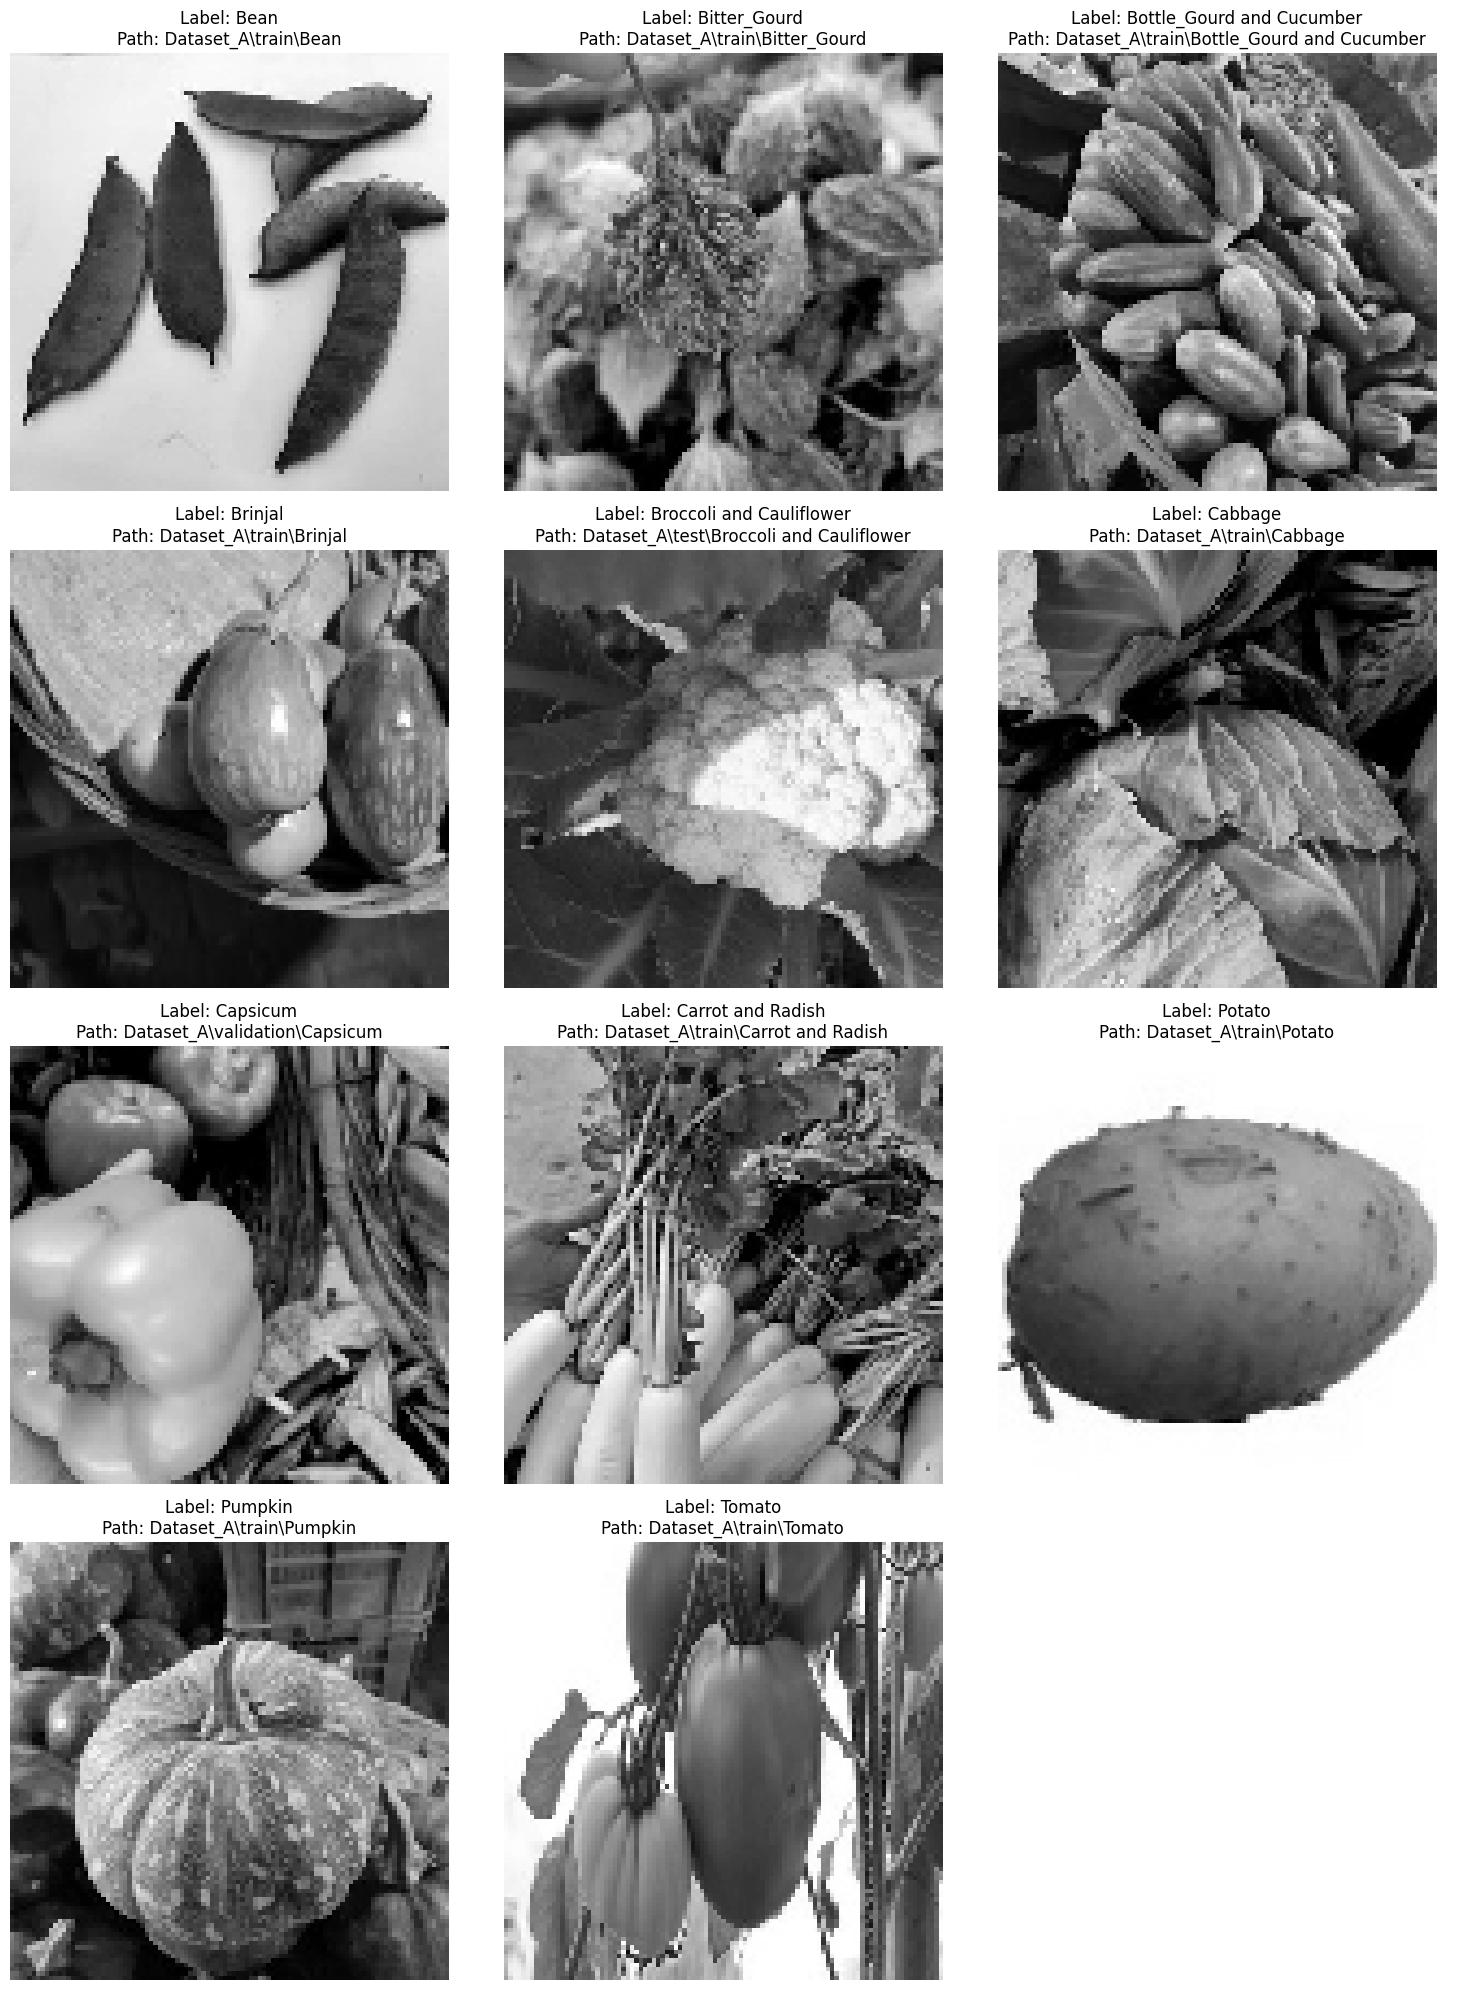

In [30]:
def display_random_images(dataset, labels):
    num_images = len(labels)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    for i, label in enumerate(labels):
        ax = axes[i]

        # Filter dataset for the current label
        filtered_data = dataset[dataset[label]]
        if not filtered_data.empty: # check if data is not empty
            # Randomly select one row
            random_row = filtered_data.sample(n=1).iloc[0]
            image = random_row['image'].squeeze()
            split = random_row['split']
            path = os.path.join(root_dir, split, label)

            ax.imshow(image, cmap='gray')
            ax.set_title(f"Label: {label}\nPath: {path}")
            ax.axis('off')
        else:
            ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# List of labels
labels = [
    'Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal',
    'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish',
    'Potato', 'Pumpkin', 'Tomato'
]

# Display random images from dataset101
display_random_images(dataset101, labels)

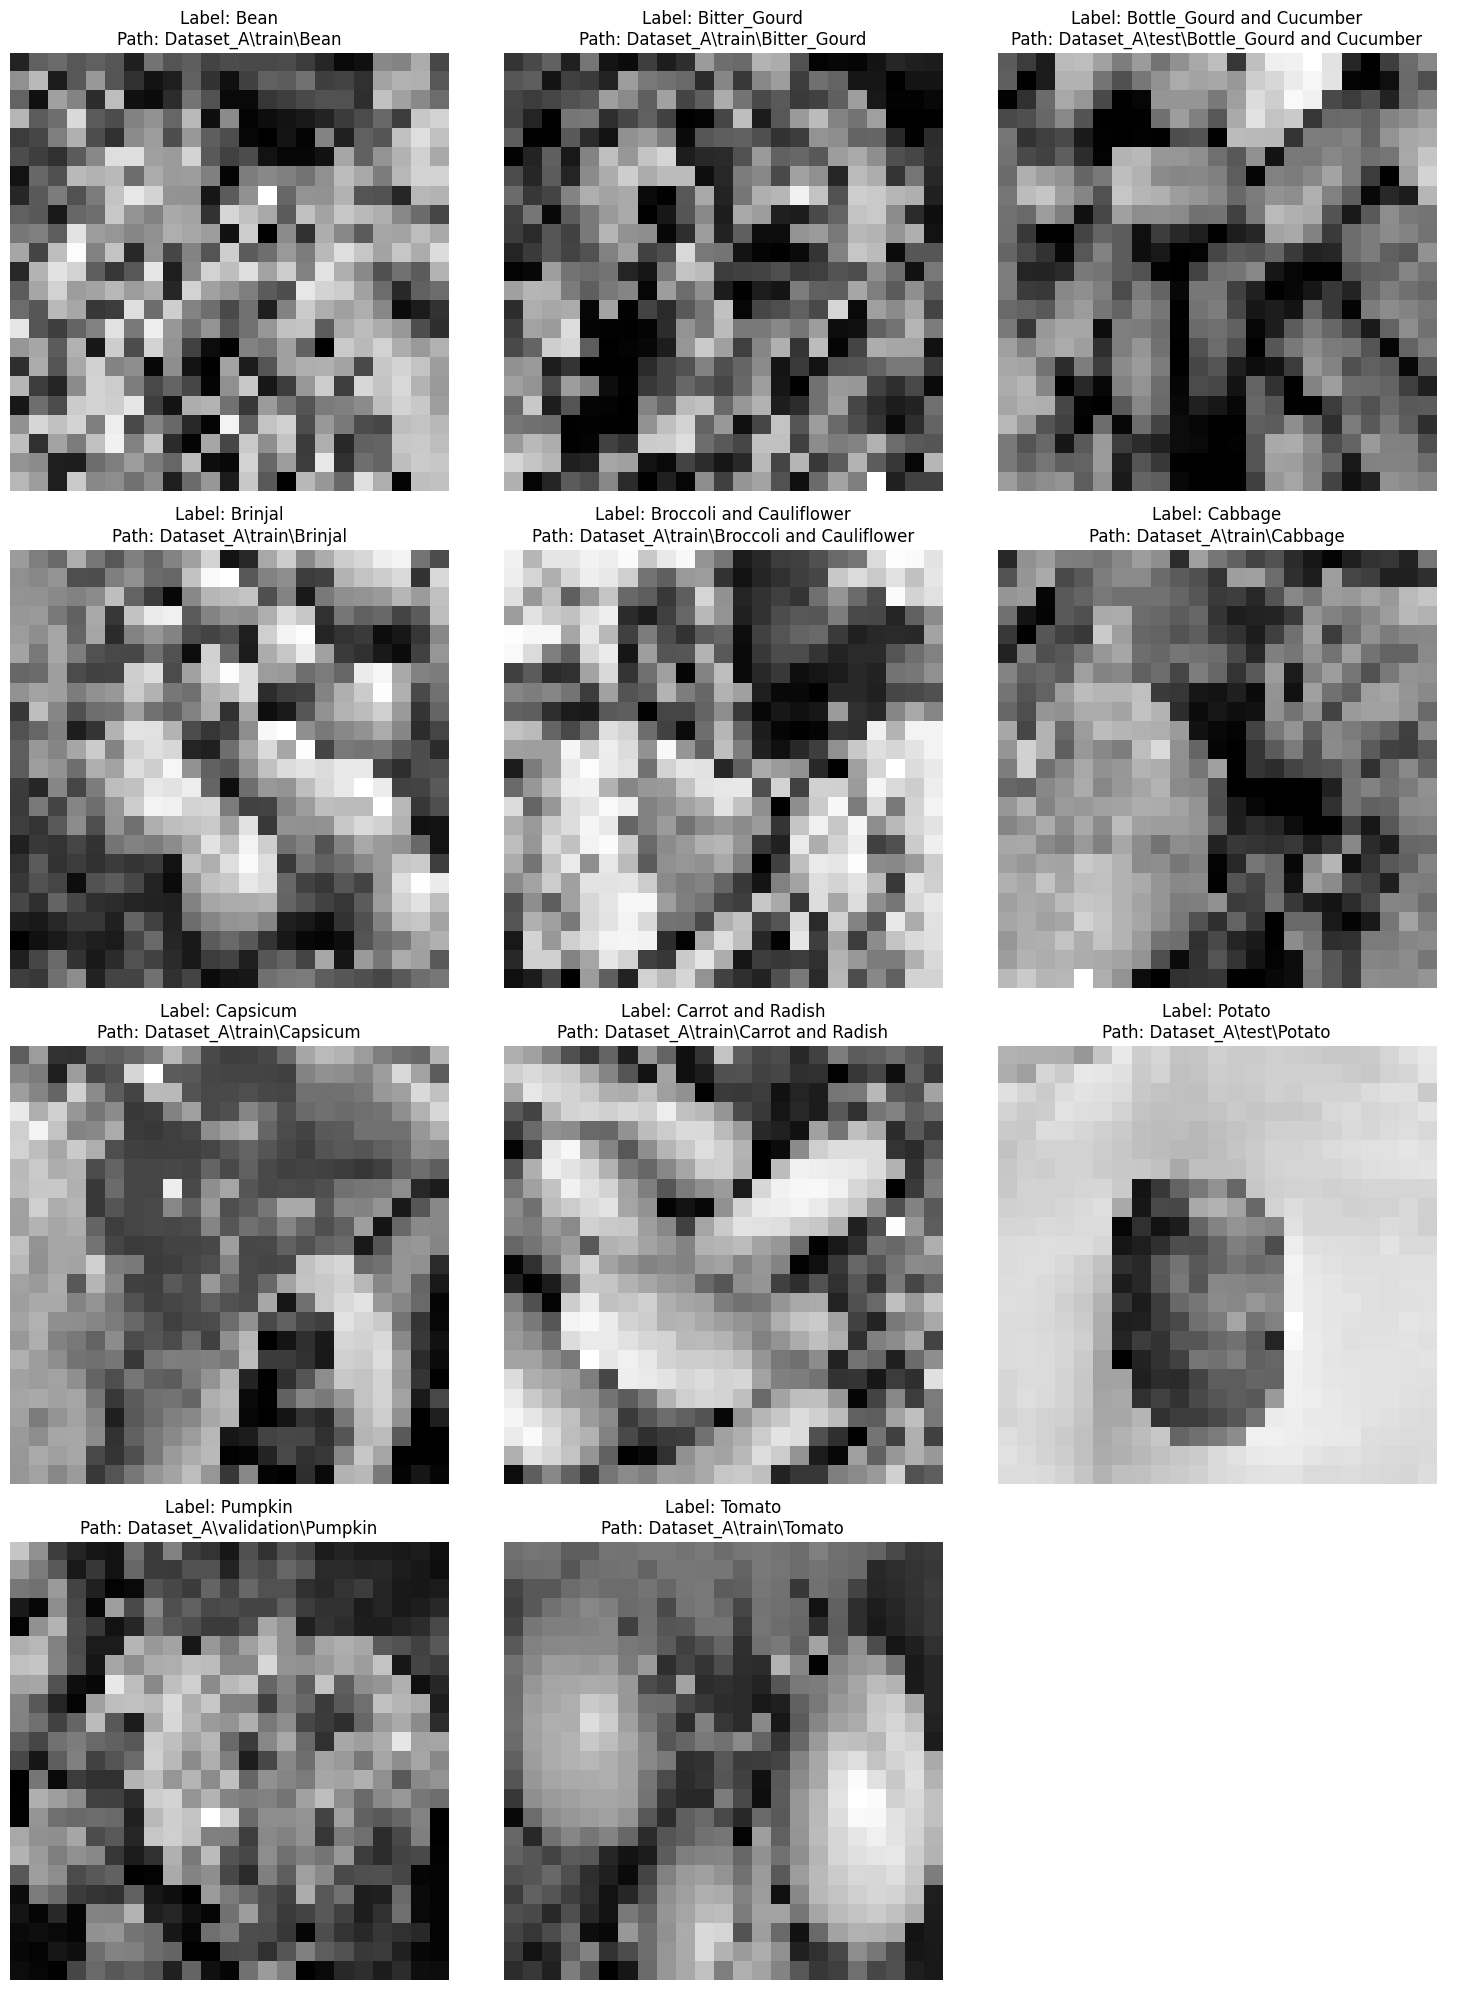

In [31]:
display_random_images(dataset23, labels)

Based on the images chosen randomly, all of the pictures appear to be labeled correctly.

### Function to save model if the model improves
---

In [32]:
def save_model_with_increment(model, current_accuracy, directory, prefix, X_test, y_test):
    """
    Save the model with an incremented number in the filename if its accuracy is better than the best saved model.

    Parameters:
    - model: The current model to evaluate.
    - current_accuracy: The accuracy of the current model.
    - directory: Directory where models are saved.
    - prefix: Prefix for the model filenames.
    - X_test, y_test: Test data for evaluating the saved models.
    """
    # Get all model files with the specified prefix
    model_files = []
    for filename in os.listdir(directory):
        if filename.startswith(prefix + "-") and filename.endswith(".h5"):
            model_files.append(os.path.join(directory, filename))
    
    # Extract numbers from filenames
    model_numbers = []
    for file in model_files:
        match = re.search(rf"{prefix}-(\d+)\.h5", file)
        if match:
            model_numbers.append(int(match.group(1)))
    
    # Determine the highest number
    max_number = max(model_numbers) if model_numbers else 0
    best_model_path = os.path.join(directory, f"{prefix}-{max_number}.h5")
    
    # Load the best model if it exists
    if os.path.exists(best_model_path):
        best_model = tf.keras.models.load_model(best_model_path)
        best_accuracy = best_model.evaluate(X_test, y_test, verbose=0)[1]
    else:
        best_accuracy = 0

    # Compare accuracies and save the model if it's better
    if current_accuracy > best_accuracy:
        new_model_path = os.path.join(directory, f"{prefix}-{max_number + 1}.h5")
        print(f"New model has better accuracy ({current_accuracy:.2f}) than the best saved model ({best_accuracy:.2f}). Saving the model as {new_model_path}...")
        model.save(new_model_path)
    else:
        print(f"Current model accuracy ({current_accuracy:.2f}) is not better than the best saved model ({best_accuracy:.2f}).")

### First Model (101x101)
---

#### Creating Model Function

In [33]:
# The layers in the model are chosen based on standard practices for building a CNN for image classification:

# 1. **Conv2D Layers**:
#    - The first `Conv2D` layer has 32 filters with a kernel size of (3, 3) and ReLU activation. This layer extracts low-level features like edges and textures.
#    - The second `Conv2D` layer has 64 filters with the same kernel size and activation. It extracts more complex features as the network goes deeper.

# 2. **MaxPooling2D Layers**:
#    - After each convolutional layer, a `MaxPooling2D` layer is used to reduce the spatial dimensions of the feature maps. This helps in reducing the computational cost and prevents overfitting.

# 3. **Dropout Layers**:
#    - Dropout is applied after each pooling layer and the dense layer to randomly deactivate neurons during training. This helps in preventing overfitting.

# 4. **Flatten Layer**:
#    - The `Flatten` layer converts the 2D feature maps into a 1D vector, which can be fed into the dense layers.

# 5. **Dense Layers**:
#    - A dense layer with 128 neurons and ReLU activation is used to learn high-level representations.
#    - The final dense layer has `num_classes` neurons with a softmax activation to output probabilities for each class.

# These choices are standard for image classification tasks and are designed to balance feature extraction, computational efficiency, and overfitting prevention.
# Define the CNN model
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model
                    

#### Preparing Data

In [34]:

# Prepare the data for training
X_train = np.array([np.squeeze(img) for img in dataset101[dataset101['split'] == 'train']['image']])
y_train = dataset101[dataset101['split'] == 'train'][labels].values
X_val = np.array([np.squeeze(img) for img in dataset101[dataset101['split'] == 'validation']['image']])
y_val = dataset101[dataset101['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset101[dataset101['split'] == 'test']['image']])
y_test = dataset101[dataset101['split'] == 'test'][labels].values

# Prepare dataset101 for training
input_shape = (101, 101, 1)  # Grayscale images of size 101x101
num_classes = len(labels)

# Reshape X to include the channel dimension
X_train = X_train.reshape(-1, 101, 101, 1)
X_val = X_val.reshape(-1, 101, 101, 1)

#### Compiling Model

In [35]:
# Create the model
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=15, 
                    batch_size=32)

Epoch 1/15
241/241 [==============================] - 3s 10ms/step - loss: 2.1961 - accuracy: 0.2250 - val_loss: 1.9125 - val_accuracy: 0.3518
Epoch 2/15
241/241 [==============================] - 2s 10ms/step - loss: 1.7727 - accuracy: 0.3892 - val_loss: 1.5985 - val_accuracy: 0.5068
Epoch 3/15
241/241 [==============================] - 2s 9ms/step - loss: 1.4945 - accuracy: 0.4747 - val_loss: 1.2774 - val_accuracy: 0.6136
Epoch 4/15
241/241 [==============================] - 2s 10ms/step - loss: 1.2791 - accuracy: 0.5510 - val_loss: 1.1924 - val_accuracy: 0.6264
Epoch 5/15
241/241 [==============================] - 2s 10ms/step - loss: 1.1141 - accuracy: 0.6016 - val_loss: 1.0658 - val_accuracy: 0.6700
Epoch 6/15
241/241 [==============================] - 2s 9ms/step - loss: 0.9738 - accuracy: 0.6546 - val_loss: 0.8698 - val_accuracy: 0.7300
Epoch 7/15
241/241 [==============================] - 2s 9ms/step - loss: 0.8533 - accuracy: 0.6969 - val_loss: 0.8427 - val_accuracy: 0.7477
Ep

#### Checking Accuracy

In [36]:
# Evaluate the model on the test data
X_test = X_test.reshape(-1, 101, 101, 1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 79.73%


#### Saving Modal if it improves

In [37]:

directory = "101_models"  # Directory where models are saved
prefix = "best_101_model"  # Prefix for the model filenames
model = history.model  # Get the trained model
save_model_with_increment(model, test_accuracy, directory, prefix, X_test, y_test)

Current model accuracy (0.80) is not better than the best saved model (0.82).


#### Accuracy Vs Epochs

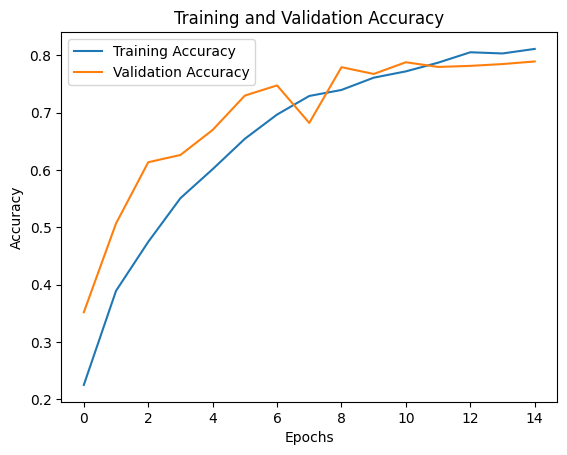

In [38]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

### First Model (23x23)
---

#### Preparing Data

In [39]:
# Prepare the data for training
X_train = np.array([np.squeeze(img) for img in dataset23[dataset23['split'] == 'train']['image']])
y_train = dataset23[dataset23['split'] == 'train'][labels].values
X_val = np.array([np.squeeze(img) for img in dataset23[dataset23['split'] == 'validation']['image']])
y_val = dataset23[dataset23['split'] == 'validation'][labels].values
X_test = np.array([np.squeeze(img) for img in dataset23[dataset23['split'] == 'test']['image']])
y_test = dataset23[dataset23['split'] == 'test'][labels].values

# Prepare dataset23 for training
input_shape = (23, 23, 1)  # Grayscale images of size 101x101
num_classes = len(labels)

# Reshape X to include the channel dimension
X_train = X_train.reshape(-1, 23, 23, 1)
X_val = X_val.reshape(-1, 23, 23, 1)


#### Compiling Modal

In [40]:
# Create the model
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=15, 
                    batch_size=32)

Epoch 1/15
241/241 [==============================] - 1s 4ms/step - loss: 2.2642 - accuracy: 0.1755 - val_loss: 2.1929 - val_accuracy: 0.2195
Epoch 2/15
241/241 [==============================] - 1s 3ms/step - loss: 2.0078 - accuracy: 0.3019 - val_loss: 1.8386 - val_accuracy: 0.3914
Epoch 3/15
241/241 [==============================] - 1s 3ms/step - loss: 1.8085 - accuracy: 0.3842 - val_loss: 1.6859 - val_accuracy: 0.4723
Epoch 4/15
241/241 [==============================] - 1s 3ms/step - loss: 1.6675 - accuracy: 0.4431 - val_loss: 1.5375 - val_accuracy: 0.4941
Epoch 5/15
241/241 [==============================] - 1s 3ms/step - loss: 1.5425 - accuracy: 0.4795 - val_loss: 1.3984 - val_accuracy: 0.5473
Epoch 6/15
241/241 [==============================] - 1s 3ms/step - loss: 1.4363 - accuracy: 0.5086 - val_loss: 1.3112 - val_accuracy: 0.5705
Epoch 7/15
241/241 [==============================] - 1s 3ms/step - loss: 1.3396 - accuracy: 0.5437 - val_loss: 1.2335 - val_accuracy: 0.6032
Epoch 

#### Checking Accuracy

In [41]:
# Evaluate the model on the test data
X_test = X_test.reshape(-1, 23, 23, 1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 70.32%


#### Accuracy Vs Epochs

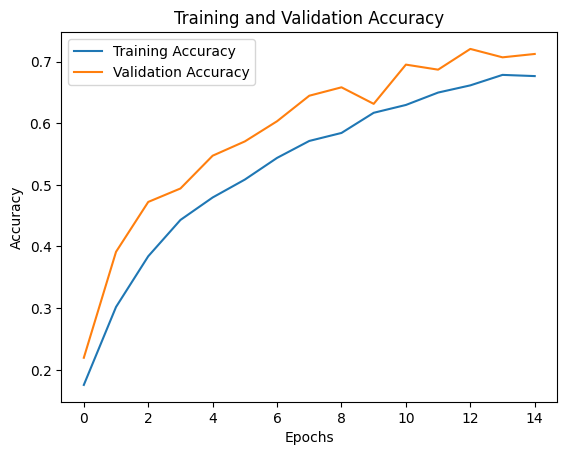

In [42]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

#### Saving Modal if it improves

In [43]:

directory = "23_models"  # Directory where models are saved
prefix = "best_23_model"  # Prefix for the model filenames
model = history.model  # Get the trained model
save_model_with_increment(model, test_accuracy, directory, prefix, X_test, y_test)

Current model accuracy (0.70) is not better than the best saved model (0.75).


### Testing if removing duplicates improves accuracy

#### Checking duplicates

In [44]:

# Convert the 'image' column to a NumPy array
images = np.array([img.squeeze() for img in dataset101['image']])

# Reshape each image into a 1D array
flattened_images = images.reshape(images.shape[0], -1)

# Use NumPy's unique function to find unique rows
_, unique_indices, counts = np.unique(flattened_images, axis=0, return_index=True, return_counts=True)

# Count duplicates
num_duplicates_101 = len(flattened_images) - len(unique_indices)
print(f"Number of duplicate entries in dataset101: {num_duplicates_101}")

# Optional: Get indices of duplicate images
duplicate_indices = np.where(counts > 1)[0]
print(f"Indices of duplicate images: {duplicate_indices}")

Number of duplicate entries in dataset101: 17
Indices of duplicate images: [  419  1226  2570  2829  3840  4473  4760  5488  5924  6461  8398  9339
 10176 10553 10712 11004 11540]


In [45]:
# Filter dataset101 to keep only unique images
dataset101_unique = dataset101.iloc[unique_indices].reset_index(drop=True)

# Filter dataset23 to keep only unique images
dataset23_unique = dataset23.iloc[unique_indices].reset_index(drop=True)

print(f"Original dataset101 size: {len(dataset101)}, Unique dataset101 size: {len(dataset101_unique)}")
print(f"Original dataset23 size: {len(dataset23)}, Unique dataset23 size: {len(dataset23_unique)}")

Original dataset101 size: 12110, Unique dataset101 size: 12093
Original dataset23 size: 12110, Unique dataset23 size: 12093
